In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#pip install -U scikit-learn
import sklearn

In [3]:
sklearn.__version__ #tiene que ser scikit-learn>=0.23 para que imblearn funcione

'0.23.1'

# ÍNDICE

1. Descripción datasets
        1.1. Artistas musicales `df_artistas`
        1.2. Canciones de Spotify `df_canciones`
2. Pre-processing de los datos
        2.1. Tratamiento valores ausente (missings)
        2.2. Creación y modificación variables
             - Modificación variable 'Genres' de `df_artistas`
             - Creación variable 'featuring' en `df_canciones`
             - Creación variable 'main artist' en `df_canciones`
        2.3. Merge de `df_artistas` y `df_canciones`
        2.4. Tratamiento datos atípicos (outliers)
        2.4. Conversión de variables categóricas a variables dummy
        2.5. Definición del dataset final
3. Análisis descriptivo de los datos

4. Aplicación modelos
        4.1. Problemática datos desbalanceados
        4.2. Modelo con parámetro 'balanced'
        4.3. RobustScaler
        4.4. RobustScaler y reducción dimesionalidad (PCA)
        4.5. Selección del mejor modelo
5. Conclusiones

# 1. DESCRIPCIÓN DATASETS

Se han tomado dos datasets diferentes:
- **Un dataset de canciones de Spotify**, que contiene un listado de canciones en Spotify de la de decada de los 10's, desde el 1 de enero de 2010 hasta el 31 de diciembre de 2019, obtenidas a través de la API de Spotify Web. Presenta un desglose detallado de cómo son y cómo suenan "técnicamente" estas canciones. Además, viene incluida la variable 'target', que será nuestro objeto a estudiar: vale 1 si la canción fue un éxito (hit), ó 0 si la canción no fue popular (no hit). El hecho de que se etiquete como 1 ó 0 sigue un criterio subjetivo que el propio autor del dataset explica:

> target: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'. The author's condition of a track being 'flop' is as follows:
>- The track must not appear in the 'hit' list of that decade.
>- The track's artist must not appear in the 'hit' list of that decade.
>- The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 
>- The track's genre must not have a song in the 'hit' list.
>- The track must have 'US' as one of its markets.

- **Un dataset de artistas musicales**:

> Data on tenured Billboard artists who appeared on Billboard between July 1999 and July 2019, released at least 3 albums, and released their first album no later than 2012. These are artists to be considered tenured popular artists. The file has demographic, genre, and history data on them

La idea es ampliar el dataset de las canciones de Spotify con características propias de los artistas, y no únicamente de lo "bien o mal" que suenan las canciones. De esta forma, podemos estudiar si hay alguna relación causal entre las características musicales y personales del artista con el hecho de que una canción se convierta en un 'hit'.

La **aplicación** de este modelo en el mundo real está enfocado en las discográficas, de tal forma que puedan predecir de antemano (antes de firmar un contrato discográfico con un artista desconocido, por ejemplo) si sus canciones pueden convertirse en un 'hit' o no vayan a ser populares.

**Nota**: como el dataset de artistas musicales está compuesto por artistas que ya tienen una trayectoria, seguramente muchas de las canciones 'no hit' no encontrarán su cruce en el dataset de los artistas musicales, por lo que lidiaremos con ello más adelante.

## 1.1. Artistas musicales

https://www.kaggle.com/danield2255/data-on-songs-from-billboard-19992019

Las variables del dataset que se han seleccionado son:

- **Genres**: los géneros musicales que canta el artista
- **Gender**: el sexo de éste
- **Group.Solo**: 'Group' cuando es una banda, 'Solo' cuando canta en solitario

In [4]:
df_artistas = pd.read_csv('artistDf.csv', sep=',')
df_artistas = df_artistas.drop(['X','YearFirstAlbum','Followers','NumAlbums'], axis=1)
df_artistas #1035 artistas con 3 características

,Artist,Genres,Gender,Group.Solo
0,Ed Sheeran,"pop,uk pop",M,Solo
1,Justin Bieber,"canadian pop,dance pop,pop,post-teen pop",M,Solo
2,Jonas Brothers,"boy band,dance pop,pop,post-teen pop",M,Group
3,Drake,"canadian hip hop,canadian pop,hip hop,pop rap,...",M,Solo
4,Chris Brown,"dance pop,pop,pop rap,r&b,rap",M,Solo
...,...,...,...,...
1030,Dwight Yoakam,"country,country rock,nashville sound,outlaw co...",M,Solo
1031,Jordan Knight,NaN,M,Solo
1032,Lila McCann,"contemporary country,country,country dawn",F,Solo
1033,Everlast,rap rock,M,Solo


En el dataset original había disponible datos como el número de seguidores en Spotify (`Followers`) o el número de álbumes publicados (`NumAlbums`), pero se ha decidido eliminarlos porque provocaría cierto sesgo en los resultados. El objetivo es predecir "a ciegas" si una canción va a ser un 'hit' o no en base únicamente a características de la canción y del artista. Si el artista ya tuviera una reputación y una consolidada carrera musical (= gran número de seguidores y muchos álbumes publicados), cualquier canción que publique tiene más probabilidades de triunfar que una canción de las mismas características de una persona desconocida.

## 1.2. Canciones de Spotify

https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset?select=dataset-of-10s.csv


- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- **key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

- **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:

- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:

- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- **duration_ms**:  The duration of the track in milliseconds.

- **time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **chorus_hit**: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **sections**: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

In [5]:
df_canciones = pd.read_csv('dataset-of-10s.csv', sep=',')
df_canciones = df_canciones.drop('uri', axis=1)
df_canciones #6398 canciones con 18 características

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000000,0.0828,0.7060,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814000,0.0946,0.2500,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000000,0.1080,0.2740,172.065,205463,4,44.89147,9,1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000000,0.2040,0.2910,91.837,193043,4,29.52521,7,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000000,0.3910,0.7800,160.517,144244,4,24.99199,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6393,Lotus Flowers,Yolta,0.172,0.358,9,-14.430,1,0.0342,0.88600,0.966000,0.3140,0.0361,72.272,150857,4,24.30824,7,0
6394,Calling My Spirit,Kodak Black,0.910,0.366,1,-9.954,1,0.0941,0.09960,0.000000,0.2610,0.7400,119.985,152000,4,32.53856,8,1
6395,Teenage Dream,Katy Perry,0.719,0.804,10,-4.581,1,0.0355,0.01320,0.000003,0.1390,0.6050,119.999,227760,4,20.73371,7,1
6396,Stormy Weather,Oscar Peterson,0.600,0.177,7,-16.070,1,0.0561,0.98900,0.868000,0.1490,0.5600,120.030,213387,4,21.65301,14,0


# 2. PRE-PROCESSING DE LOS DATOS

## 2.1.  Tratamiento valores ausentes

In [6]:
df_artistas.isnull().sum()

Artist         0
Genres        18
Gender        84
Group.Solo    16
dtype: int64

Como son ejemplos reales de artistas, habría que ir caso a caso corrigiéndolos manualmente con sus valores correctos, por lo que se ha decidido por eliminar esas filas en vez de tratarlos.

In [7]:
df_artistas = df_artistas.dropna()
df_artistas = df_artistas.reset_index(drop=True) 
#IMPORTANTE para regenerar los índices de nuevo (si no se hace, quedan vacíos los índices de las filas con valores NA borradas)

In [8]:
df_canciones.isnull().sum()

track               0
artist              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

No tiene ningún valor missing

## 2.2. Creación y modificación variables

### Modificación variable 'Genres' de `df_artistas`

In [9]:
df_artistas['Genres']

0                                             pop,uk pop
1               canadian pop,dance pop,pop,post-teen pop
2                   boy band,dance pop,pop,post-teen pop
3      canadian hip hop,canadian pop,hip hop,pop rap,...
4                          dance pop,pop,pop rap,r&b,rap
                             ...                        
929    argentine rock,cantautor,folklore argentino,nu...
930    country,country rock,nashville sound,outlaw co...
931            contemporary country,country,country dawn
932                                             rap rock
933    alternative metal,alternative rock,pop rock,po...
Name: Genres, Length: 934, dtype: object

Como la variable `Genres` presenta varios géneros musicales para un mismo artista, vamos a hacerlo más sencillo cogiendo aleatoriamente sólo uno de la lista.

In [10]:
import random

#A cada elemento de df_artistas['Genres'] (listageneros es una cadena de strings), separo la cadena en los diferentes strings 
#con .split() y mediante random.sample() cojo una muestra aleatoria de tamaño 1:
random.seed(0)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda listageneros: random.sample(listageneros.split(','),1)[0]) 

In [11]:
len(set(df_artistas['Genres']))

220

Hay 220 géneros distintos, lo cual implicaría 219 variables dummies en un modelo de regresión. Vamos a reducir los géneros en grupos más genéricos como: `pop`, `rock`, `hip hop`, `latin`, `r&b`, `electro/techno`, `country/folk` y `other` 

Para organizarlos por grupos de forma sistemática, vamos a establecer una regla: si el género es un mix de dos géneros o más, nos quedamos con el género con el que termina. Por ejemplo: *latin hip hop* lo asignamos a `hip hop`, aunque sea `latin` también.

In [12]:
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'pop' if genero.split()[-1] == 'pop' else genero)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'rock' if genero.split()[-1] == 'rock' else genero)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'hip hop' if genero.split()[-1] == 'hop' else genero)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'latin' if genero.split()[-1] == 'latin' else genero)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'r&b' if genero.split()[-1] == 'r&b' else genero)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'electro/techno' if genero.split()[-1] == 'techno' else genero)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'country/folk' if genero.split()[-1] == 'country' else genero)
df_artistas.loc[:,'Genres'] = df_artistas['Genres'].apply(lambda genero: 'country/folk' if genero.split()[-1] == 'folk' else genero)

In [13]:
len(set(df_artistas['Genres']))

129

Hemos reducido de 220 a 129, pero no es suficiente. Échemos un vistazo a los géneros restantes:

In [14]:
set(df_artistas['Genres'])

{'adult standards',
 'alabama metal',
 'alternative metal',
 'anthem worship',
 'australian dance',
 'australian talent show',
 'bachata',
 'big beat',
 'big room',
 'birmingham metal',
 'boy band',
 'british soul',
 'britpop',
 'bubble trance',
 'bubblegum dance',
 'canadian metal',
 'canadian punk',
 'ccm',
 'celtic',
 'christian indie',
 'christian music',
 'classical tenor',
 'comic',
 'country dawn',
 'country gospel',
 'country road',
 'country/folk',
 'crunk',
 'dancehall',
 'deep norteno',
 'deep talent show',
 'dirty south rap',
 'disco',
 'downtempo',
 'easy listening',
 'easycore',
 'edm',
 'electro house',
 'electro/techno',
 'electropop',
 'electropowerpop',
 'emo',
 'europop',
 'finnish edm',
 'folk-pop',
 'funk',
 'funk metal',
 'gangster rap',
 'girl group',
 'gospel',
 'group',
 'grunge',
 'hip hop',
 'hollywood',
 'hyphy',
 'idol',
 'indie pop rap',
 'indiecoustica',
 'italo dance',
 'japanese singer-songwriter',
 'k-hop',
 'k-pop girl group',
 'kids dance party',
 'l

Para reducir la lista en una segunda vuelta, hay que asociar géneros concretos a cada una de las categorías:
- `pop`: boy band, britpop, electropop, electropowerpop, europop, folk-pop, idol, k-pop girl group
- `rock`: easycore, emo, grunge, indie, mellow gold, metal, neo mellow, permanent wave, pixie, post-grunge, punk, rock-and-roll, rock en espanol, screamo
- `hip hop`: dancehall, k-hop, rap, reggae, reggae fusion, riddim, trap music, trap queen
- `latin`: bachata, reggaeton, tropical
- `r&b`: blues, disco, funk, gospel, jazz, motown, new jack swing, quiet storm, soul, urban contemporary
- `electro/techno`: dance, edm, house, trance
- `country/folk`: celtic, country dawn, country road, nashville sound, redneck

In [15]:
dicc_generos = {
    'pop': ['boy band', 'britpop', 'electropop', 'electropowerpop', 'europop', 'folk-pop', 'idol', 'k-pop girl group'],
    'rock': ['easycore', 'emo', 'grunge', 'indie', 'mellow gold', 'metal', 'neo mellow', 'permanent wave', 'pixie', 'post-grunge', 'punk', 'rock-and-roll', 'rock en espanol', 'screamo'],
    'hip hop': ['dancehall', 'k-hop', 'rap', 'reggae', 'reggae fusion', 'riddim', 'trap music', 'trap queen'],
    'latin': ['bachata', 'reggaeton', 'tropical'],
    'r&b': ['blues', 'disco', 'funk', 'gospel', 'jazz', 'motown', 'swing', 'quiet storm', 'soul', 'urban contemporary'],
    'electro/techno': ['dance', 'edm', 'house', 'trance'],
    'country/folk': ['celtic', 'country dawn', 'country road', 'nashville sound', 'redneck']
}

En esta nueva ocasión, establecemos la misma regla: si el género coincide o termina en algunos de los géneros propuestos, se le asignará la 'key' correspondiente. Por ejemplo: `canadian punk` termina en `punk`, por lo que tendrá la etiqueta final de `rock`.

In [16]:
num_artistas = df_artistas.shape[0] #numero de artistas total
generos_values = df_artistas['Genres'].values
for artista in range(num_artistas):
    for i in dicc_generos: #i es un string que recorre las keys del diccionario: 'pop', 'rock', etc.
        long_lista = len(dicc_generos[i])
        for j in range(long_lista): #j toma valores enteros que recorren la lista de subgéneros del diccionario
            last_word = generos_values[artista].split()[-1]
            if ((last_word == dicc_generos[i][j]) or (generos_values[artista] == dicc_generos[i][j])): 
            #si la última palabra del string o el string entero coincide con los valores del diccionario:
                df_artistas.loc[artista,'Genres'] = i #sustituyo ese género por la key correspondiente

In [17]:
pd.value_counts(df_artistas['Genres'])

rock                          220
pop                           214
hip hop                       198
country/folk                  112
r&b                           107
electro/techno                 20
latin                          14
lilith                          5
adult standards                 5
comic                           3
soca                            3
hyphy                           2
hollywood                       2
easy listening                  2
anthem worship                  2
deep talent show                1
scorecore                       1
group                           1
sertanejo                       1
australian talent show          1
girl group                      1
big beat                        1
crunk                           1
ccm                             1
deep norteno                    1
worship                         1
indiecoustica                   1
japanese singer-songwriter      1
big room                        1
christian musi

El resto de géneros que no sean de `dicc_generos` los etiquetaremos como `other`

In [18]:
#lista de géneros principales
lista_generos = list(dicc_generos.keys())
lista_generos

['pop', 'rock', 'hip hop', 'latin', 'r&b', 'electro/techno', 'country/folk']

In [19]:
index_generos = set()
for i in lista_generos:
    index_generos = set(np.where(df_artistas['Genres'] == i)[0]) | index_generos #todos los índices de artistas que pertenecen a lista_generos, | hace la unión

index_other = list(set(range(num_artistas)) - index_generos) #índices de artistas de género 'other'
df_artistas.loc[index_other,'Genres'] = 'other' #los clasifico como 'other'

In [20]:
pd.value_counts(df_artistas['Genres'])

rock              220
pop               214
hip hop           198
country/folk      112
r&b               107
other              49
electro/techno     20
latin              14
Name: Genres, dtype: int64

In [21]:
pd.value_counts(df_artistas['Genres']).sum() == num_artistas #para comprobar que da la suma total de las filas

True

### Creación variable 'featuring' en `df_canciones`

Algunas canciones presentan colaboraciones, es decir, que el cantante principal canta con uno o más artistas. Vamos a incorporar esta característica como variable explicativa y ver si es influyente o no a la hora de que una canción se vuelva un hit.

Con los datos de `df_canciones`, las colaboraciones se pueden identificar de dos formas:
- En la categoría `artist` viene incluida la palabra *Featuring* (mayoritariamente), *featuring* o *feat.*
- En la categoría `track` viene incluida la palabra *(feat.* (mayoritariamente) o *featuring*

Cabe mencionar que hay canciones que son colaboraciones pero que vienen reflejado de otra forma: lista de artistas separados por comas, por &, etc. En estos casos, se supondrán que no son colaboraciones, ya que podría confundirse con nombres de artistas que presentan dichos caracteres (ejemplo: Zay Hilfigerrr & Zayion McCall es una colaboración pero Mumford & Sons es una banda).

Vamos a definir una función auxiliar que detecte si dentro de una cadena está presente una palabra en concreto:

In [22]:
def contener(cadena, palabra):
    contener = 0
    if (cadena.find(palabra) == -1): #.find() devuelve -1 cuando la palabra no está en la cadena
        contener = 0 #devuelvo 0 si la cadena no contiene la palabra
    else:
        contener = 1
    return contener

#Ejemplo:
contener('Tengo un perro verde', 'verde')

1

Filtrando por `artist`, las palabras clave son *Featuring, featuring* y *feat.*

In [23]:
num_canciones = df_canciones.shape[0] #número de canciones total
cadena = df_canciones['artist'].values

for i in range(num_canciones):
    if ((contener(cadena[i],'Featuring')==1) or (contener(cadena[i],'featuring')==1) or (contener(cadena[i],'feat.')==1)):
        df_canciones.loc[i,'featuring'] = 1 #creo una columna llamada 'featuring', que vale 1 si es una colaboración
    else:
        df_canciones.loc[i,'featuring'] = 0
        

df_canciones['featuring'].sum() 

902.0

Filtrando por `track`, las palabras a buscar son *(feat.* y *featuring*

In [24]:
cadena = df_canciones['track'].values

for i in range(num_canciones):
    if ((contener(cadena[i],'(feat.')==1) or (contener(cadena[i],'featuring')==1)):
        df_canciones.loc[i,'featuring'] = 1
        #superpone el valor de 'featuring' del bucle anterior: si ya valía 1 y se detecta de nuevo como colaboración, sobreescribe
        #con un 1 de nuevo; si valía 0 y se detecta ahora como colaboración, lo cambia a 1.
        

df_canciones['featuring'].sum()

984.0

En una primera vuelta (filtrando por `artist`), había 902 colaboraciones. Filtrando a continuación por `track`, hemos obtenido un total de 984 colaboraciones.

In [25]:
#Por último, convertimos la columna a tipo integer
df_canciones = df_canciones.astype({'featuring': int})

### Creación variable 'main artist' en `df_canciones`

El valor de `artist` en aquellas canciones que sean colaboraciones tendrán la forma de *Pepito Featuring Juanito* (entre otras variantes). Esto provoca problemas de cruce entre los dos dataframes (mediante `merge`), porque aunque *Pepito* esté en el dataset de artistas `df_artistas`, no hará match con las canciones que tiene colaborando, solo las que tenga en solitario. Por lo tanto, nos interesa sacar el nombre del cantante principal, que será todo lo que venga antes de la palabra *Featuring*.

Primero, vamos a crear una función auxiliar que haga dicha acción.

In [26]:
def cortar(cadena, palabra): 
    if (contener(cadena, palabra) == 1):
        return cadena[0:(cadena.find(palabra)-1)]
        #.find devuelve la posición de 'palabra' en 'cadena', por lo que devolvemos el string desde el principio hasta
        #la posición anterior a 'palabra' (para no incluir el espacio)
    
#Ejemplo
cortar('Tengo un perro verde','verde')

'Tengo un perro'

Creamos la columna `main artist` de la siguiente forma:

In [27]:
for i in range(num_canciones):
    if df_canciones.loc[i,'featuring'] == 1: #si es una colaboración
        
        #Si se detecta que es una colaboración por la categoría 'artist'
        if contener(df_canciones.loc[i,'artist'],'Featuring') == 1: #mediante la palabra 'Featuring'
            df_canciones.loc[i,'main artist'] = cortar(df_canciones.loc[i,'artist'],'Featuring')
        elif contener(df_canciones.loc[i,'artist'],'featuring') == 1: #mediante la palabra 'featuring'
            df_canciones.loc[i,'main artist'] = cortar(df_canciones.loc[i,'artist'],'featuring')
        elif contener(df_canciones.loc[i,'artist'],'feat.') == 1: #mediante la palabra 'feat.'
            df_canciones.loc[i,'main artist'] = cortar(df_canciones.loc[i,'artist'],'feat.')
        
        #Cuando se detecta que es una colaboración por la categoría 'track'
        else:
            df_canciones.loc[i,'main artist'] = df_canciones.loc[i,'artist'] #se queda con el mismo artist
            
    else: #si no es una colaboración
        df_canciones.loc[i,'main artist'] = df_canciones.loc[i,'artist'] #se queda con el mismo artist

In [28]:
#Vamos a ver unos ejemplos para ver si se ha ejecutado bien
index_featuring = np.where(df_canciones['featuring'] == 1)[0] #los índices de las canciones colaboraciones
df_canciones.loc[index_featuring,['track','artist','main artist']]

,track,artist,main artist
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,Keys N Krates
9,My Last,Big Sean Featuring Chris Brown,Big Sean
16,Cut Her Off,KCamp Featuring 2 Chainz,KCamp
17,Beautiful People,Chris Brown Featuring Benny Benassi,Chris Brown
19,Squidwards Nose (feat. Kg Prince),Joey Trap,Joey Trap
...,...,...,...
6345,10 Freaky Girls,Metro Boomin Featuring 21 Savage,Metro Boomin
6348,Headlights,Eminem Featuring Nate Ruess,Eminem
6368,Bend Ova,Lil Jon Featuring Tyga,Lil Jon
6385,Death,Trippie Redd Featuring DaBaby,Trippie Redd


##  2.3. Merge de `df_artistas` y `df_canciones`

Finalmente, vamos a cruzar las dos tablas para obtener el dataset completo. Cruzamos mediante `df_canciones['main artist']` y `df_artistas['Artist']`

In [29]:
pd.options.display.max_columns = None #muestra todas las columnas

In [30]:
df_titulos = pd.merge(df_canciones, df_artistas, left_on = 'main artist', right_on = 'Artist') #cruzamos las dos tablas
df_titulos = df_titulos.drop(['Artist', 'main artist'], axis=1) #nos quedamos solo con 'artist'
df_titulos

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,featuring,Genres,Gender,Group.Solo
0,Here's To Never Growing Up,Avril Lavigne,0.482,0.873,0,-3.145,1,0.0853,0.01110,0.000000,0.4090,0.737,165.084,214320,4,32.17301,12,1,0,pop,F,Solo
1,Alice,Avril Lavigne,0.536,0.824,0,-4.403,1,0.0767,0.04580,0.000199,0.1740,0.172,119.004,300987,4,27.44375,11,1,0,pop,F,Solo
2,Wish You Were Here,Avril Lavigne,0.454,0.865,4,-3.841,1,0.0561,0.03230,0.000000,0.1860,0.340,166.018,225760,4,28.77377,11,1,0,pop,F,Solo
3,Let Me Go,Avril Lavigne Featuring Chad Kroeger,0.385,0.654,4,-6.635,1,0.0342,0.21200,0.000000,0.1360,0.125,164.196,267973,3,43.48854,12,1,1,pop,F,Solo
4,Smile,Avril Lavigne,0.634,0.848,1,-3.843,0,0.0470,0.00237,0.000000,0.0681,0.647,105.055,209520,4,39.65995,8,1,0,pop,F,Solo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,I'm Awesome,Spose,0.478,0.933,0,-5.814,1,0.3530,0.54000,0.000000,0.9230,0.442,98.949,179774,4,34.78117,6,1,0,other,M,Solo
1633,Cough Syrup,Young The Giant,0.534,0.721,11,-7.307,0,0.0417,0.03430,0.000006,0.1150,0.225,128.978,249520,3,44.87267,10,1,0,rock,M,Group
1634,Hold You (Hold Yuh),Gyptian,0.690,0.621,8,-3.583,1,0.0600,0.32100,0.000028,0.0884,0.497,66.858,233253,3,69.65459,9,1,0,rock,M,Solo
1635,Window Seat,Erykah Badu,0.643,0.535,0,-6.795,0,0.0941,0.64800,0.002130,0.0766,0.564,82.193,289720,4,30.38643,15,1,0,r&b,F,Solo


In [31]:
pd.value_counts(df_titulos['target'])

1    1604
0      33
Name: target, dtype: int64

In [32]:
(1 - sum(df_titulos['target'])/len(df_titulos['target']))*100

2.0158827122785605

A pesar de haber creado la variable `main artist` para intentar maximizar el mayor número de cruces posibles con `df_artistas`, se observa una pérdida considerable de canciones debido a que no encuentra *match* en la base de datos de `df_artistas`. Probablemente se deba por la naturaleza de éste, ya que contiene información de artistas ya conocidos. Esto provoca que los datos estén totalmente desbalanceados: las canciones 'no hit' representan únicamente un 2% de la muestra total.

Al no haber sido posible encontrar otro dataset de artistas más "completo" (con artistas más y menos conocidos), intentareamos lidiar con este desajuste con varios métodos de desbalanceamiento que más adelante se explicarán.

## 2.4. Tratamiento datos atípicos

In [33]:
def filtrar_outlier_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1 
    
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [34]:
var_names_cont = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','chorus_hit']
#var_names_cont son las variables explicativas continuas

dicc = {}
idx_outliers = set()
for variable in var_names_cont:
    indices, values = filtrar_outlier_tukey(df_titulos[variable])
    if indices == []:
        dicc[variable] = 'no hay outliers'
    else:
        dicc[variable] = ('hay outliers', len(indices))
        idx_outliers = set(indices) | idx_outliers #devuelve los índices totales con outliers
        
dicc

{'danceability': ('hay outliers', 4),
 'energy': ('hay outliers', 19),
 'loudness': ('hay outliers', 54),
 'speechiness': ('hay outliers', 180),
 'acousticness': ('hay outliers', 137),
 'instrumentalness': ('hay outliers', 346),
 'liveness': ('hay outliers', 87),
 'valence': 'no hay outliers',
 'tempo': ('hay outliers', 1),
 'duration_ms': ('hay outliers', 72),
 'chorus_hit': ('hay outliers', 73)}

La única feature que no presenta outliers es `valence`, mientras que variables como `instrumentalness` o `acousticness` presentan una cantidad considerable de éstos.

Para afrontar este problema, hay varias formas de tratarlo:
- **Eliminando los outliers** (la forma más fácil) 

El inconveniente es que estaríamos eliminando información que podría ser valiosa y seguramente también estaríamos eliminando canciones 'no hit', que ya de por sí son pocos.

In [35]:
pd.value_counts(df_titulos['target'])

1    1604
0      33
Name: target, dtype: int64

In [36]:
(1 - sum(df_titulos['target'])/len(df_titulos['target']))*100 #porcentaje que representa 'no hit' sin eliminar outliers

2.0158827122785605

In [37]:
df_sinoutliers = df_titulos.drop(list(idx_outliers)) #elimino los índices de los outliers 
pd.value_counts(df_sinoutliers['target']) 

1    916
0     15
Name: target, dtype: int64

In [38]:
(1 - sum(df_sinoutliers['target'])/len(df_sinoutliers['target']))*100 #porcentaje que representa 'no hit' eliminando outliers

1.6111707841031109

En efecto, se reduce la proporción de 'no hit' en la muestra de un 2% a un 1.6%, por lo que no es aconsejable eliminarlos.

- **Sustituyendo por el valor de la mediana**: pero teniendo en cuenta que estamos tomando casos reales, estaríamos manipulando los datos de forma incorrecta y no reflejaría la realidad


- **Utilizando `RobustScaler`** (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html?highlight=robust#sklearn.preprocessing.RobustScaler)

Este técnica es bastante útil ya que no elimina los outliers sino que reduce su efecto mediante un re-escalado parecido a `StandardScaler`. En este caso lo que hace es restar la mediana y dividir por el rango intercuartílico (valor 75% - valor 25%). Aplicaremos este re-escalado más adelante para comprobar si su práctica mejora la métrica o no.

##  2.5. Conversión a variables dummy

In [39]:
#Convertimos a dummy todas menos 'track' y 'artist', de ahí que recorra [2:]
variables_dummy = pd.get_dummies(df_titulos.iloc[:,2:], drop_first=True) #drop_first=True elimina una dummy

#Concatenamos con la transformación anterior
df = pd.concat([df_titulos.loc[:,['track','artist']], variables_dummy], axis=1)
df = df.rename(columns={'Group.Solo_Solo': 'Solo'}) #renombranos la variable a 'Solo'

In [40]:
df.head() #elimina Genres_country/folk

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,featuring,Genres_electro/techno,Genres_hip hop,Genres_latin,Genres_other,Genres_pop,Genres_r&b,Genres_rock,Gender_M,Solo
0,Here's To Never Growing Up,Avril Lavigne,0.482,0.873,0,-3.145,1,0.0853,0.01110,0.000000,0.4090,0.737,165.084,214320,4,32.17301,12,1,0,0,0,0,0,1,0,0,0,1
1,Alice,Avril Lavigne,0.536,0.824,0,-4.403,1,0.0767,0.04580,0.000199,0.1740,0.172,119.004,300987,4,27.44375,11,1,0,0,0,0,0,1,0,0,0,1
2,Wish You Were Here,Avril Lavigne,0.454,0.865,4,-3.841,1,0.0561,0.03230,0.000000,0.1860,0.340,166.018,225760,4,28.77377,11,1,0,0,0,0,0,1,0,0,0,1
3,Let Me Go,Avril Lavigne Featuring Chad Kroeger,0.385,0.654,4,-6.635,1,0.0342,0.21200,0.000000,0.1360,0.125,164.196,267973,3,43.48854,12,1,1,0,0,0,0,1,0,0,0,1
4,Smile,Avril Lavigne,0.634,0.848,1,-3.843,0,0.0470,0.00237,0.000000,0.0681,0.647,105.055,209520,4,39.65995,8,1,0,0,0,0,0,1,0,0,0,1


A la hora de crear dummies, se ha añadido el parámetro `drop_first=True` para que no hubiera problemas de multicolinealidad en un modelo de regresión logit. Al eliminar una dummy de cada grupo, las variables convertidas dejan de ser combinación lineal de la eliminada.

##  2.6. Definición del dataset final

El dataset final con el que trabajaremos de ahora en adelante será el siguiente:

In [41]:
df = df.drop(['track','artist'], axis=1)

num_col_y = list(df.columns).index('target') 
# .index devuelve la posición de un elemento en una lista (en este caso, el número de columna de 'target')

X_df = pd.concat([df.iloc[:,:num_col_y], df.iloc[:,num_col_y+1:]], axis=1)
#concateno todas las columnas salvo la de la posición de 'target' (num_col_y)

X = X_df.values
y = df['target'].values

X.shape, y.shape

((1637, 25), (1637,))

Y está compuesto por 25 variables explicativas:

In [42]:
var_names = X_df.columns #orden de las variables explicativas en el df
var_names

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'featuring',
       'Genres_electro/techno', 'Genres_hip hop', 'Genres_latin',
       'Genres_other', 'Genres_pop', 'Genres_r&b', 'Genres_rock', 'Gender_M',
       'Solo'],
      dtype='object')

# 3. ANÁLISIS DESCRIPTIVO

In [43]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,featuring,Genres_electro/techno,Genres_hip hop,Genres_latin,Genres_other,Genres_pop,Genres_r&b,Genres_rock,Gender_M,Solo
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,0.628671,0.701253,5.279780,-5.756099,0.680513,0.103482,0.145057,0.005418,0.188077,0.507295,124.068037,229857.250458,3.986561,39.408715,10.197312,0.979841,0.320098,0.017715,0.298106,0.014661,0.008552,0.301772,0.064753,0.094685,0.784973,0.869884
std,0.138869,0.161416,3.630375,2.129558,0.466420,0.102785,0.193880,0.046572,0.142841,0.215039,28.922202,44053.922344,0.215114,17.846976,2.464574,0.140586,0.466656,0.131955,0.457566,0.120228,0.092110,0.459167,0.246164,0.292869,0.410967,0.336534
min,0.209000,0.077500,0.000000,-18.067000,0.000000,0.022500,0.000025,0.000000,0.024100,0.037900,61.115000,78200.000000,3.000000,14.275530,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.537000,0.598000,2.000000,-6.777000,0.000000,0.037800,0.018100,0.000000,0.095600,0.344000,99.980000,203160.000000,4.000000,27.491960,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.626000,0.724000,6.000000,-5.465000,1.000000,0.056600,0.062100,0.000000,0.127000,0.502000,124.987000,223840.000000,4.000000,35.302940,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.723000,0.823000,8.000000,-4.329000,1.000000,0.125000,0.193000,0.000013,0.243000,0.660000,142.657000,247813.000000,4.000000,46.092160,12.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,0.974000,0.991000,11.000000,-0.716000,1.000000,0.681000,0.987000,0.867000,0.962000,0.976000,208.067000,688453.000000,5.000000,213.154990,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Si nos fijamos en las variables continuas, la media de algunas variables tienden a estar más próxima a uno de los valores extremos (el mínimo y el máximo), como se aprecia en `energy` (media de 0.7 en un rango de [0.07, 0.99]) o `acousticness` (media de 0.14 en un rango de [0, 0.98]). Esto nos da una idea de que las variables no son del todo normales, sino que tendrán cierto grado de asimetría.

In [44]:
import seaborn as sns
sns.set_style("whitegrid")

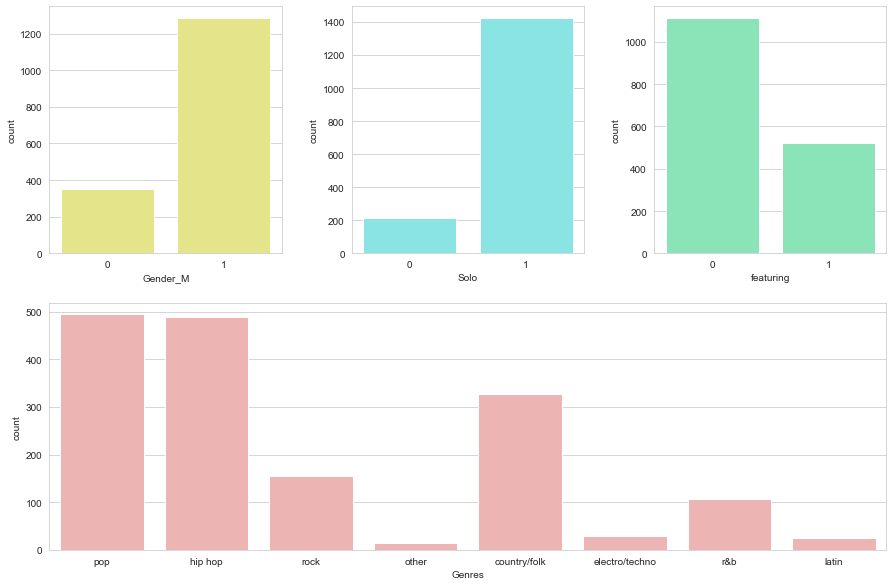

In [45]:
fig = plt.figure(1, figsize=(15,10));
grid = plt.GridSpec(2, 3, wspace=0.3, width_ratios=[1, 1, 1], height_ratios=[0.5, 0.5]) #2 filas, 3 columnas

#Fila 0
plt.subplot(grid[0, 0])
sns.countplot(x="Gender_M", data=df, color='#F3F37B');
plt.subplot(grid[0, 1])
sns.countplot(x="Solo", data=df, color='#7BF3F3');
plt.subplot(grid[0, 2])
sns.countplot(x="featuring", data=df, color='#7BF3B7');

#Fila 1
plt.subplot(grid[1, :])
sns.countplot(x="Genres", data=df_titulos, color='#F7AAAA');

Por cada feature, predominan canciones de artistas masculinos, en solitario, de tipo colaboración, y principalmente de pop y hip-hop.

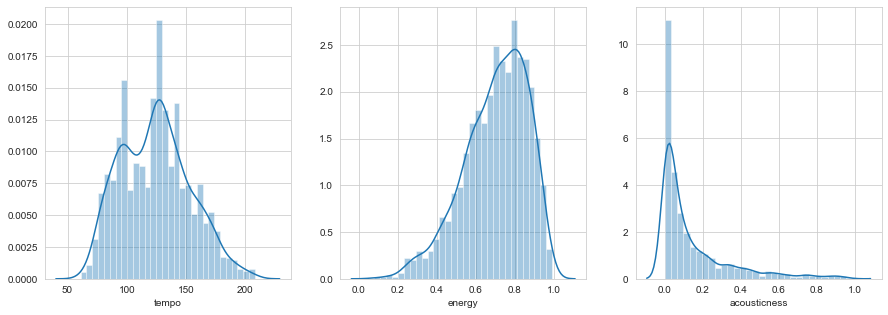

In [46]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

sns.distplot(df['tempo'], kde=True, bins=30, ax=axs[0]);
sns.distplot(df['energy'], kde=True, bins=30, ax=axs[1]);
sns.distplot(df['acousticness'], kde=True, bins=30, ax=axs[2]);

En efecto, no se aprecia un comportamiento "normal": `tempo` es bimodal, `acousticness` es asimétrica hacia la izquierda y `energy` es asimétrica hacia la derecha. Teniendo en cuenta esto, emplearemos los modelos de **regresión logística, random forest y k-Vecinos** en el modelado de nuestro conjunto de datos, ya que no precisan que las variables independientes sigan una distribución normal (como sí lo impone el análisis discriminación lineal (LDA), por ejemplo).

# 4. APLICACIÓN MODELOS

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0) 
    #stratify=y es para que se conserve la misma proporción de 0/1 tanto en train como en test

In [48]:
y.sum()/len(y), y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.9798411728772144, 0.9799126637554585, 0.9796747967479674)

El 98% de las canciones del dataset son 'hit'

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1145, 25), (1145,), (492, 25), (492,))

**¿Qué métrica es la más adecuada en este caso?** https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Aunque la tasa de aciertos (*accuracy*) es una métrica bastante útil por lo general, la presencia de desbalanceamiento que hay en el dataset provoca que la tasa de aciertos no sea nada representativa, ya que el modelo tenderá a predecir únicamente la clase predominante y proporcionará tasas muy altas pero engañosas. 

Por este motivo, nos centraremos en detectar y minimizar el peso de los falsos negativos y positivos. Esto es:

- **Efecto falso negativo**: desde el punto de vista de la discográfica que implementa este modelo, el beneficio que le hubiera retribuido haber fichado al verdadero 'hit' mal clasificado (falso negativo) supone un elevado coste de oportunidad. Es decir, al ser rechazado por la discográfica, el artista de este 'hit' podría tomar la decisión de irse a otra discográfica de la competencia que sí supiera detectar que es un verdadero 'hit'. Además, no sólo supone una pérdida económica para la discográfica, sino un incremento de popularidad y visibilidad a la otra discográfica de la competencia.

- **Efecto falso positivo**: hacen referencia a canciones que son realmente 'no hit' pero que el modelo predice como 'hit'. Reducir estos falsos 'hit' ayudaría a la discográfica a no incurrir en costes de inversión en un activo (artista) que no les va a reportar grandes beneficios.

Para minimizar estos impactos, `recall` es la métrica más apropiada, que mide lo siguiente:

$$
recall_{hit} = \dfrac{TruePositive}{TruePositive + FalseNegative}
$$

es decir, expresa cuán bien el modelo sabe detectar 'hits' de todos los posibles que hay. Y análogo con la clase 'no hit':

$$
recall_{\text{no hit}} = \dfrac{TrueNegative}{TrueNegative + FalsePositive}
$$


Para tener en cuenta tanto el $recall_{hit}$ como el $recall_{\text{no hit}}$, utilizaremos como métrica `recall_macro` (la media general de los dos tipos de recall), para que ambos efectos tengan el mismo peso (si utilizáramos `recall_weighted`, $recall_{hit}$ tendría mayor peso por ser la clase mayoritaria)

## 4.1. Problemática datos desbalanceados

Como el dataset presenta una clara desproporción entre canciones de tipo 0 (clase minoritaria) y canciones de tipo 1 (clase mayoritaria), esto se puede corregir de diversas maneras:

- **Estableciendo parámetros al modelo** 

Modelos como el de regresión logística o el de random forest presentan un parámetro denominado `class_weight='balanced'` que penalizan a la clase mayoritaria durante el entrenamiento para intentar equilibrar a la clase minoritaria.

>The *balanced* mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`

Es decir, cuanto mayor sea el número de elementos de una clase, menor peso se le asignará.


- **Haciendo subsampling de la clase mayoritaria y/o oversampling de la clase minoritaria**: 

<img src=https://oralytics.files.wordpress.com/2019/05/screenshot-2019-05-20-15.34.14.png>

Cuando se aplica **subsampling** para reducir la clase mayoritaria, se utiliza un algortimo similar a k-Vecinos que va seleccionando de forma aleatoria cuáles eliminar. Como nuestra clase minoritaria sólo está compuesto por 33 canciones, no tiene sentido aplicar dicho procedimiento ya que nuestro conjunto de datos se reduciría considerablemente y habría muy pocos datos para entrenar.

Sin embargo, la estrategia del **oversampling** pretende aumentar la clase minoritaria y se puede conseguir de dos formas: 1) replicando copias exactas de forma aleatoria, o 2) creando nuevas muestras sintéticas muy parecidas a las muestras ya existentes. El método 2) es lo que se demonina SMOTE (*Synthetic Minority Oversampling Technique*). 

<img src=https://www.bbvadata.com/wp-content/uploads/2017/10/1-3.jpg>

SMOTE genera datos sintéticos también básandose en k-Vecinos: fija un punto minoritario, encuentra sus vecinos minoritarios más cercanos, selecciona al azar uno de ellos y emplea interpolación lineal entre ambos puntos para producir un nuevo dato "minoritario".

Asimismo, también se puede hacer una combinación simultánea entre **subsampling** y **oversampling** y es lo que se denomina SMOTE-TOMEK.

Para nuestro caso, abordaremos el problema de la siguiente forma: aplicaremos SMOTE sobre el conjunto de entrenamiento de tal forma que se crean nuevas muestras 'no hit', como hemos explicado. Por defecto, se crean tantas muestras minoritarias como sean necesarias hasta que se iguale al número de muestras mayoritarias. En nuestro caso, para que no haya tantas muestras "inventadas" y no caiga en overfitting el modelo, estableceremos un ratio de ambas del 30%. De esta forma, aunque el conjunto de entrenamiento siga desbalanceado, lo estará en menor medida. Para compensar esto, aplicaremos además el parámetro `class_weight='balanced'` que corregirán este defecto y penalizará a las muestras mayoritarias.

## 4.2. Modelos originales con parámetro 'balanced'

In [50]:
#pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

from collections import Counter

In [51]:
os = SMOTE(sampling_strategy=0.3, random_state=0) #establezco el ratio de 0.3
X_train_os, y_train_os = os.fit_sample(X_train, y_train)
 
print ("Antes de SMOTE {}".format(Counter(y_train)))
print ("Después de SMOTE {}".format(Counter(y_train_os)))

Antes de SMOTE Counter({1: 1122, 0: 23})
Después de SMOTE Counter({1: 1122, 0: 336})


Veamos primero cómo se comporta cada modelo entrenado sin muestras artificiales y luego con ellas (SMOTE), y así comprobar si las predicciones son mejores en el caso de haber aplicado SMOTE.

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def cv(modelo, X_train, y_train):
    cv = GridSearchCV(estimator=modelo, param_grid={}, cv=10, scoring='recall_macro', n_jobs=-1)
    cv.fit(X_train, y_train)

    y_pred = cv.predict(X_test)
    
    resultados = {'mejor recall_macro CV': cv.best_score_,
                  'matriz confusion': metrics.confusion_matrix(y_test, y_pred),
                  'recall_macro test': metrics.recall_score(y_test, y_pred, average='macro'),
                  'accuracy test': metrics.accuracy_score(y_test, y_pred)}
    
    return resultados, y_pred

- **REGRESIÓN LOGÍSTICA**

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=10000) #solver='lbfgs' por defecto

In [76]:
cv_lr = cv(lr, X_train, y_train)
cv_lr[0]

{'mejor recall_macro CV': 0.5531618731563422,
 'matriz confusion': array([[  4,   6],
        [231, 251]], dtype=int64),
 'recall_macro test': 0.4603734439834025,
 'accuracy test': 0.5182926829268293}

In [77]:
cv_lr_os = cv(lr, X_train_os, y_train_os)
cv_lr_os[0]

{'mejor recall_macro CV': 0.5689933304375653,
 'matriz confusion': array([[  5,   5],
        [235, 247]], dtype=int64),
 'recall_macro test': 0.5062240663900415,
 'accuracy test': 0.5121951219512195}

Teniendo en cuenta que sólo hay 10 canciones 'no hit' en todo el conjunto test, el modelo que los detecta ligeramente mejor es el modelo con SMOTE implementado (5 de 10), aunque la precisión de la clase 'no hit' no es muy buena. Asimismo, el promedio de las `recall_macro` durante el cross-validation también es ligeramente mayor con SMOTE. Si bien es cierto que el `accuracy` en el test es menor, daremos más importancia en saber detectar las muestras minoritarias.

- **RANDOM FOREST**

In [56]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced_subsample')

In [78]:
cv_rfc = cv(rfc, X_train, y_train)
cv_rfc[0]

{'mejor recall_macro CV': 0.49910714285714286,
 'matriz confusion': array([[  0,  10],
        [  0, 482]], dtype=int64),
 'recall_macro test': 0.5,
 'accuracy test': 0.9796747967479674}

In [79]:
cv_rfc_os = cv(rfc, X_train_os, y_train_os)
cv_rfc_os[0]

{'mejor recall_macro CV': 0.9735699961802903,
 'matriz confusion': array([[  0,  10],
        [  0, 482]], dtype=int64),
 'recall_macro test': 0.5,
 'accuracy test': 0.9796747967479674}

Con random forest, ninguno de los dos modelos sabe predecir '0' a pesar de que presenten un accuracy tan alto y engañoso. Aunque en el caso de SMOTE el `recall_macro` alcanzado en train es muy alto, esto nos indica que el modelo tiende a hacer overfitting porque luego en el test no sabe predecir correctamente muestras nuevas.

- **KNN**

In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [80]:
cv_knn = cv(knn, X_train, y_train)
cv_knn[0]

{'mejor recall_macro CV': 0.5, 'matriz confusion': array([[  0,  10],
        [  0, 482]], dtype=int64), 'recall_macro test': 0.5, 'accuracy test': 0.9796747967479674}

In [81]:
cv_knn_os = cv(knn, X_train_os, y_train_os)
cv_knn_os[0]

{'mejor recall_macro CV': 0.5834927202980951,
 'matriz confusion': array([[  4,   6],
        [ 37, 445]], dtype=int64),
 'recall_macro test': 0.6616182572614109,
 'accuracy test': 0.9126016260162602}

Con k-Vecinos, se puede ver claramente que el modelo mejora con SMOTE: consigue predecir 4 de 10 canciones 'no hit', mientras que en el modelo normal no predice ni una y es un modelo inútil que sólo predice 1's.

## 4.3. Robust Scaler

Ahora que sabemos que con SMOTE se consiguen mejores predicciones, vamos a implementarlo directamente para el resto de modelados que se hagan. En esta sección, aplicaremos `RobustScaler()` para corregir la influencia de los outliers.

In [62]:
from sklearn.preprocessing import RobustScaler

rb = RobustScaler()
X_train_rb = rb.fit_transform(X_train_os)
X_test_rb = rb.transform(X_test)

- **REGRESIÓN LOGÍSTICA**

In [63]:
#lr = LogisticRegression(class_weight='balanced', max_iter=10000) #solver='lbfgs' por defecto

cv_lr_rb = GridSearchCV(estimator=lr, param_grid={}, cv=10, scoring='recall_macro', n_jobs=-1)
cv_lr_rb.fit(X_train_rb, y_train_os) 

rec_lr_rb = cv_lr_rb.best_score_
rec_lr_rb 

0.8702583416713427

In [64]:
y_pred_lr_rb = cv_lr_rb.predict(X_test_rb)

conf_lr_rb = metrics.confusion_matrix(y_test, y_pred_lr_rb)
conf_lr_rb

array([[  4,   6],
       [ 90, 392]], dtype=int64)

In [65]:
print(metrics.classification_report(y_test, y_pred_lr_rb))

              precision    recall  f1-score   support

           0       0.04      0.40      0.08        10
           1       0.98      0.81      0.89       482

    accuracy                           0.80       492
   macro avg       0.51      0.61      0.48       492
weighted avg       0.97      0.80      0.87       492



In [66]:
#Accuracy y recall_macro de las predicciones
pred_lr_rb = metrics.accuracy_score(y_test, y_pred_lr_rb), metrics.recall_score(y_test, y_pred_lr_rb, average='macro')
pred_lr_rb

(0.8048780487804879, 0.6066390041493777)

In [67]:
#Coeficientes del modelo
cv_lr_rb.best_estimator_.intercept_, cv_lr_rb.best_estimator_.coef_

(array([2.40541445]),
 array([[-1.44554771e+00, -3.44991225e+00, -6.97820572e-01,
          1.06663104e+00,  2.80252659e-01, -4.09725780e-01,
          2.35346621e-01, -1.63020958e-04,  2.67116127e-01,
          9.92687841e-01,  3.03421575e-01,  9.15757873e-02,
          6.13848036e-01, -1.01381604e-02,  5.57623791e-02,
          1.27853098e+00, -1.91421984e+00, -3.06999468e+00,
          1.11024978e+00,  1.25055496e-01, -1.54234362e+00,
          1.17839184e+00, -2.60041700e+00, -3.23226093e+00,
          3.82570971e-02]]))

Estudiemos la significatividad de los coeficientes utilizando otra librería `statsmodel`: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html

In [68]:
#Vamos a obtener los p-valores de los coeficientes

import statsmodels.api as sm

X_train_rb_lr = sm.add_constant(X_train_rb) #para añadir la constante al modelo
 
model = sm.Logit(y_train_os, X_train_rb_lr)
result = model.fit(method='nm', maxiter=100000) #'nm' for Nelder-Mead
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.460057
         Iterations: 8597
         Function evaluations: 10426
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1458
Model:                          Logit   Df Residuals:                     1432
Method:                           MLE   Df Model:                           25
Date:                Sun, 05 Jul 2020   Pseudo R-squ.:                  0.1478
Time:                        12:19:19   Log-Likelihood:                -670.76
converged:                       True   LL-Null:                       -787.06
Covariance Type:            nonrobust   LLR p-value:                 1.429e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0981      0.199      5.513      0.000       0.708 

Si se hubiera utilizado el solver por defecto `method='lbfgs'`, los coeficientes hubieran salido 0. Se ha cambiado por `method='nm'` para que no diera problemas de convergencia y para que además no saltara el error `LinAlgError: Singular matrix`.

Nota: los coeficientes no coinciden con los de scikit-learn, a parte de porque no es el mismo solver, probablemente porque hemos añadido el parámetro `class_weight='balanced'` en el modelo de scikit-learn y con statsmodel no se tiene en cuenta.

In [69]:
idx_pvalues = np.argsort(result.pvalues)[1:]-1 #no tenemos en cuenta el coeficiente de la constante
pvalues = result.pvalues[1:][idx_pvalues]

dicc_pvalues = dict(zip(var_names[idx_pvalues],pvalues))
dicc_pvalues

{'speechiness': 3.0137013353836626e-08,
 'Solo': 0.015530118898523921,
 'instrumentalness': 1.4846857731236508e-07,
 'mode': 0.00040815765054810283,
 'valence': 0.0004104796983163923,
 'Genres_electro/techno': 0.0006231794683849974,
 'chorus_hit': 0.0022277070775079504,
 'time_signature': 0.010446313196032285,
 'sections': 0.06974241597574335,
 'key': 0.07725329561145923,
 'energy': 0.08550161030294591,
 'danceability': 0.15812288656045959,
 'Gender_M': 0.15860915348257865,
 'tempo': 0.18193622062559767,
 'Genres_other': 0.20391065768688965,
 'liveness': 0.29059673862842206,
 'Genres_r&b': 0.30618437417173816,
 'Genres_latin': 0.41216873165040824,
 'Genres_rock': 0.6927309696333834,
 'Genres_hip hop': 0.8526372650348006,
 'loudness': 0.8947835904639533,
 'Genres_pop': 0.9087885730424918,
 'duration_ms': 0.9352765593088321,
 'featuring': 0.9776893062956398}

In [70]:
for i in dicc_pvalues:
    if dicc_pvalues[i] < 0.1:
        print((i,dicc_pvalues[i]))

('speechiness', 3.0137013353836626e-08)
('Solo', 0.015530118898523921)
('instrumentalness', 1.4846857731236508e-07)
('mode', 0.00040815765054810283)
('valence', 0.0004104796983163923)
('Genres_electro/techno', 0.0006231794683849974)
('chorus_hit', 0.0022277070775079504)
('time_signature', 0.010446313196032285)
('sections', 0.06974241597574335)
('key', 0.07725329561145923)
('energy', 0.08550161030294591)


Resultado pobre, solo 11 variables del total de 25 son estadísticamente significativas: rechazan la hipótesis nula ($H_0: \beta_i=0, H_1: \beta_i\neq 0$), al menos a un 10% de significancia

- **RANDOM FOREST**

Con random forest de hecho no haría falta calcular el efecto de `RobustScaler()` porque se mantiene invariante ante re-escalados (los árboles de decisión no tienen en cuenta 'distancias', sino que maneja conceptos como el coeficiente de Gini o la ganancia de información). Veamos que sale lo mismo que en el apartado anterior.

In [71]:
rfc = RandomForestClassifier(class_weight='balanced_subsample')

cv_rfc_rb = GridSearchCV(estimator=rfc, param_grid={}, cv=10, scoring='recall_macro', n_jobs=-1)
cv_rfc_rb.fit(X_train_rb, y_train_os)

rec_rfc_rb = cv_rfc_rb.best_score_
rec_rfc_rb

0.9735699961802903

In [72]:
y_pred_rfc_rb = cv_rfc_rb.predict(X_test_rb)

conf_rfc_rb = metrics.confusion_matrix(y_test, y_pred_rfc_rb)
conf_rfc_rb

array([[  0,  10],
       [  0, 482]], dtype=int64)

In [73]:
#Accuracy y recall_macro de las predicciones
pred_rfc_rb = metrics.accuracy_score(y_test, y_pred_rfc_rb), metrics.recall_score(y_test, y_pred_rfc_rb, average='macro')
pred_rfc_rb

(0.9796747967479674, 0.5)

Presencia de overfitting en el modelo, el modelo predicho sólo sabe predecir 1's.

In [82]:
#Resultados anteriores
cv_rfc_os[0]

{'mejor recall_macro CV': 0.9735699961802903,
 'matriz confusion': array([[  0,  10],
        [  0, 482]], dtype=int64),
 'recall_macro test': 0.5,
 'accuracy test': 0.9796747967479674}

- **KNN**

In [83]:
knn = KNeighborsClassifier()

cv_knn_rb = GridSearchCV(estimator=knn, param_grid={}, cv=10, scoring='recall_macro', n_jobs=-1)
cv_knn_rb.fit(X_train_rb, y_train_os)

rec_knn_rb = cv_knn_rb.best_score_
rec_knn_rb

0.8952962782055701

In [84]:
y_pred_knn_rb = cv_knn_rb.predict(X_test_rb)

conf_knn_rb = metrics.confusion_matrix(y_test, y_pred_knn_rb)
conf_knn_rb

array([[  2,   8],
       [ 71, 411]], dtype=int64)

In [86]:
print(metrics.classification_report(y_test, y_pred_knn_rb))

              precision    recall  f1-score   support

           0       0.03      0.20      0.05        10
           1       0.98      0.85      0.91       482

    accuracy                           0.84       492
   macro avg       0.50      0.53      0.48       492
weighted avg       0.96      0.84      0.89       492



In [87]:
#Accuracy y recall_macro de las predicciones
pred_knn_rb = metrics.accuracy_score(y_test, y_pred_knn_rb), metrics.recall_score(y_test, y_pred_knn_rb, average='macro')
pred_knn_rb

(0.8394308943089431, 0.5263485477178423)

## 4.4. RobustScaler y reducción dimensionalidad (PCA)

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Al haber tantas variables explicativas, lo más seguro es que haya correlación entre ellas. Aplicaremos PCA para reducir dimesiones, estableciendo 1 como mínimo número de componentes y 13 como número máximo (la mitad del número de variables independientes).

- **REGRESIÓN LOGÍSTICA**

In [89]:
pipe = Pipeline([
    ('rb', RobustScaler()), #re-escalar
    ('pca', PCA()), #dimensionalizar
    ('lr', LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=-1)), #clasificar y predecir
])

prof = list(range(1, 14))

cv_pipe_lr = GridSearchCV(pipe, h_parameters, cv=10, n_jobs=-1, scoring='recall_macro') #le pasamos la tubería

cv_pipe_lr.fit(X_train_os, y_train_os)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('rb', RobustScaler()), ('pca', PCA()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13]},
             scoring='recall_macro')

In [90]:
cv_pipe_lr.best_params_

{'pca__n_components': 13}

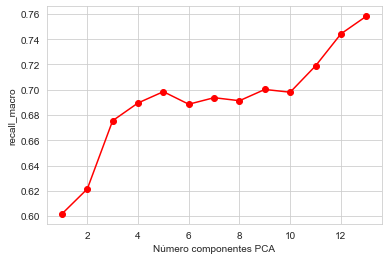

In [91]:
x = range(1,14)
y = cv_pipe_lr.cv_results_['mean_test_score']

plt.plot(x, y,'o-r')
plt.grid(True)
plt.xlabel('Número componentes PCA');
plt.ylabel('recall_macro');

El `recall_macro` presenta una tendencia positiva a medida que aumenta el número de componentes, pero el máximo se obtiene con 13 componentes, con el siguiente valor:

In [92]:
rec_pipe_lr = cv_pipe_lr.best_score_
rec_pipe_lr

0.7581813266336301

In [93]:
conf_pipe_lr = metrics.confusion_matrix(y_test, cv_pipe_lr.predict(X_test))
conf_pipe_lr

array([[  5,   5],
       [131, 351]], dtype=int64)

In [94]:
#Accuracy y recall_macro de las predicciones
pred_pipe_lr = metrics.accuracy_score(y_test, cv_pipe_lr.predict(X_test)), metrics.recall_score(y_test, cv_pipe_lr.predict(X_test), average='macro')
pred_pipe_lr

(0.7235772357723578, 0.6141078838174274)

- **RANDOM FOREST**

In [95]:
pipe2 = Pipeline([
    #('rb', RobustScaler()), #no se ve afectado
    ('pca', PCA()), #dimensionalizar
    ('rfc', RandomForestClassifier(class_weight='balanced_subsample')), #clasificar y predecir
])

comps = list(range(1,14))
arboles = [100,300,500]
h_parameters = {'pca__n_components':comps, 'rfc__n_estimators':arboles}

cv_pipe_rfc = GridSearchCV(pipe2, h_parameters, cv=5, n_jobs=-1, scoring='recall_macro') 
#disminuímos el número de particiones para que nos sea tan pesado

cv_pipe_rfc.fit(X_train_os, y_train_os)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced_subsample'))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13],
                         'rfc__n_estimators': [100, 300, 500]},
             scoring='recall_macro')

In [96]:
cv_pipe_rfc.best_params_

{'pca__n_components': 11, 'rfc__n_estimators': 300}

In [97]:
cv_pipe_rfc.cv_results_['params']

[{'pca__n_components': 1, 'rfc__n_estimators': 100},
 {'pca__n_components': 1, 'rfc__n_estimators': 300},
 {'pca__n_components': 1, 'rfc__n_estimators': 500},
 {'pca__n_components': 2, 'rfc__n_estimators': 100},
 {'pca__n_components': 2, 'rfc__n_estimators': 300},
 {'pca__n_components': 2, 'rfc__n_estimators': 500},
 {'pca__n_components': 3, 'rfc__n_estimators': 100},
 {'pca__n_components': 3, 'rfc__n_estimators': 300},
 {'pca__n_components': 3, 'rfc__n_estimators': 500},
 {'pca__n_components': 4, 'rfc__n_estimators': 100},
 {'pca__n_components': 4, 'rfc__n_estimators': 300},
 {'pca__n_components': 4, 'rfc__n_estimators': 500},
 {'pca__n_components': 5, 'rfc__n_estimators': 100},
 {'pca__n_components': 5, 'rfc__n_estimators': 300},
 {'pca__n_components': 5, 'rfc__n_estimators': 500},
 {'pca__n_components': 6, 'rfc__n_estimators': 100},
 {'pca__n_components': 6, 'rfc__n_estimators': 300},
 {'pca__n_components': 6, 'rfc__n_estimators': 500},
 {'pca__n_components': 7, 'rfc__n_estimators':

Hay 39 combinaciones posibles de parámetros (13*3). Para cada una de ellas, se hace cross-validation de 3 particiones y se calcula la media de los `recall_macro` obtenidos dentro de esa combinación. El valor más alto de esos 39 será el modelo con mejores parámetros, que es el modelo con el que se hace .predict() después

In [98]:
mean_cv_rfc = cv_pipe_rfc.cv_results_['mean_test_score']

rec_100=[]
rec_300=[]
rec_500=[]
divisor=list(range(13))

for i in divisor:
    rec_100.append(mean_cv_rfc[3*i])
    rec_300.append(mean_cv_rfc[(3*i)+1])
    rec_500.append(mean_cv_rfc[(3*i)+2])

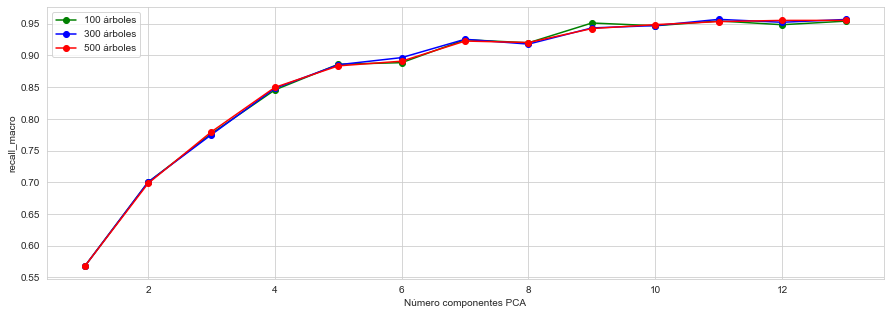

In [99]:
x = range(1,14)
plt.figure(figsize=(15,5))
plt.plot(x, rec_100, 'o-g', label='100 árboles')
plt.plot(x, rec_300, 'o-b', label='300 árboles')
plt.plot(x, rec_500, 'o-r', label='500 árboles')
plt.xlabel('Número componentes PCA')
plt.ylabel('recall_macro')
plt.legend();

Se observa que a mayor número de componentes, mayores valores de `recall_macro` se obtienen (sea cual sea el número de árboles establecido)

In [100]:
rec_pipe_rfc = cv_pipe_rfc.best_score_
rec_pipe_rfc

0.9569807126830832

In [101]:
conf_pipe_rfc = metrics.confusion_matrix(y_test, cv_pipe_rfc.predict(X_test))
conf_pipe_rfc

array([[  0,  10],
       [  1, 481]], dtype=int64)

In [102]:
#Accuracy y recall_macro de las predicciones
pred_pipe_rfc = metrics.accuracy_score(y_test, cv_pipe_rfc.predict(X_test)), metrics.recall_score(y_test, cv_pipe_rfc.predict(X_test), average='macro')
pred_pipe_rfc

(0.9776422764227642, 0.49896265560165975)

A pesar de alcanzar altos `recall_macro` durante el entrenamiento, luego en la predicción el valor es malo. Esto indica de nuevo overfitting del modelo.

- **KNN**

In [103]:
pipe3 = Pipeline([
    ('rb', RobustScaler()),
    ('pca', PCA()), #dimensionalizar
    ('knn', KNeighborsClassifier()), #clasificar y predecir
])

comps = list(range(1, 14))
vecinos = [1, 3, 5, 7, 9] #tomamos vecinos impares para que haya desempate
distancia = [1, 1.5, 2]
h_parameters = {'pca__n_components':comps, 'knn__n_neighbors':vecinos, 'knn__p':distancia}

cv_pipe_knn = GridSearchCV(pipe3, h_parameters, cv=10, n_jobs=-1, scoring='recall_macro') #le pasamos la tubería

cv_pipe_knn.fit(X_train_os, y_train_os)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('rb', RobustScaler()), ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 9],
                         'knn__p': [1, 1.5, 2],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13]},
             scoring='recall_macro')

In [104]:
cv_pipe_knn.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'pca__n_components': 12}

In [105]:
rec_pipe_knn = cv_pipe_knn.best_score_
rec_pipe_knn

0.9169136731522858

In [106]:
conf_pipe_knn = metrics.confusion_matrix(y_test, cv_pipe_knn.predict(X_test))
conf_pipe_knn

array([[  1,   9],
       [ 50, 432]], dtype=int64)

In [107]:
#Accuracy y recall_macro predicciones
pred_pipe_knn = metrics.accuracy_score(y_test, cv_pipe_knn.predict(X_test)), metrics.recall_score(y_test, cv_pipe_knn.predict(X_test), average='macro')
pred_pipe_knn

(0.8800813008130082, 0.49813278008298756)

## 4.5. Selección del mejor modelo

**RESUMEN del mejor `recall_macro` durante el SearchGridCV**

In [108]:
pd.set_option('precision', 3) #saca 3 decimales
pd.set_option('max_colwidth', 100) #para ampliar el número de caracteres dentro de una celda del dataframe

In [109]:
pd.DataFrame(np.array([[cv_lr_os[0]['mejor recall_macro CV'], cv_rfc_os[0]['mejor recall_macro CV'], cv_knn_os[0]['mejor recall_macro CV']], 
                       [rec_lr_rb, rec_rfc_rb, rec_knn_rb],
                       [rec_pipe_lr, rec_pipe_rfc, rec_pipe_knn],
                       [cv_pipe_lr.best_params_, cv_pipe_rfc.best_params_, cv_pipe_knn.best_params_]]), 
             columns=['Log Regression', 'Random Forest', 'k-Vecinos'],
             index=['parametro balanced','+ robust scaler','+ PCA','best params']
            )

,Log Regression,Random Forest,k-Vecinos
parametro balanced,0.569,0.974,0.583
+ robust scaler,0.87,0.974,0.895
+ PCA,0.758,0.957,0.917
best params,{'pca__n_components': 13},"{'pca__n_components': 11, 'rfc__n_estimators': 300}","{'knn__n_neighbors': 3, 'knn__p': 1, 'pca__n_components': 12}"


**RESUMEN de `recall_macro` de las predicciones**

In [110]:
pd.DataFrame(np.array([[cv_lr_os[0]['recall_macro test'], cv_rfc_os[0]['recall_macro test'], cv_knn_os[0]['recall_macro test']], 
                       [pred_lr_rb[1], pred_rfc_rb[1], pred_knn_rb[1]],
                       [pred_pipe_lr[1], pred_pipe_rfc[1], pred_pipe_knn[1]]]), 
             columns=['Regresion Log', 'Random Forest', 'k-Vecinos'],
             index=['parametro balanced','+ robust scaler','+ PCA']
            )

,Regresion Log,Random Forest,k-Vecinos
parametro balanced,0.506,0.500,0.662
+ robust scaler,0.607,0.500,0.526
+ PCA,0.614,0.499,0.498


**RESUMEN de `accuracy` de las predicciones**

In [112]:
pd.DataFrame(np.array([[cv_lr_os[0]['accuracy test'], cv_rfc_os[0]['accuracy test'], cv_knn_os[0]['accuracy test']], 
                       [pred_lr_rb[0], pred_rfc_rb[0], pred_knn_rb[0]],
                       [pred_pipe_lr[0], pred_pipe_rfc[0], pred_pipe_knn[0]]]), 
             columns=['Regresion Log', 'Random Forest', 'k-Vecinos'],
             index=['parametro balanced','+ robust scaler','+ PCA']
            )

,Regresion Log,Random Forest,k-Vecinos
parametro balanced,0.512,0.980,0.913
+ robust scaler,0.805,0.980,0.839
+ PCA,0.724,0.978,0.880


Comparando los `recall_macro` del CV con los `recall_macro` de las predicciones, nos damos cuenta de que hay un problema de overfitting general: los primeros son muy altos, pero los segundos son muy bajos. En especial ocurre en los 3 modelos de random forest distintos: a la hora de predecir con el conjunto test, sólo saben predecir 1's, convirtiéndolo en un modelo inservible. 

Por lo tanto, la evidencia sugiere que el modelo "ganador" que mejor rendimiento y fiabilidad tiene es el modelo de **k-Vecinos con parámetro balanced**, con un `recall_macro` de 0.662 y un `accuracy` de 0.913 en predicción (de hecho, el `recall_macro` de CV no es exageradamente alto, lo cual descarta que haya overfitting).

In [113]:
cv_knn_os[0]['matriz confusion']

array([[  4,   6],
       [ 37, 445]], dtype=int64)

De 492 canciones que conforman el conjunto test, 449 son predichas correctamente pero 43 no: hay 37 falsos negativos y 6 falsos positivos.

In [114]:
idx_fallos_test = np.where(y_test != cv_knn_os[1])[0] #los índices en el conjunto test de los casos fallidos

idx_fallos_df = []
for i in idx_fallos_test:
    idx_fallos_df.append(np.where((X_test[i] == X).sum(axis=1) == 25)[0][0])
    #La idea es buscar la fila de X que coincida exactamente con X_test[i]. Esa fila cumplirá la condición de que está compuesta
    #por 27 True, así que con np.where(la condición) obtenemos el index en X de los fallos y lo almacenamos en idx_fallos_df

df_fallos = df_titulos.loc[idx_fallos_df,['track','artist','target']]

In [115]:
#Falsos negativos
df_fallos[df_fallos['target']==1]

,track,artist,target
586,Cheers (Drink To That),Rihanna,1
28,Life After You,Daughtry,1
849,Nothing Like Us,Justin Bieber,1
1455,Burn It Down,Linkin Park,1
964,What Lovers Do,Maroon 5 Featuring SZA,1
804,Tip Of My Tongue,Kenny Chesney,1
1021,Sing,My Chemical Romance,1
569,Heartbreak Warfare,John Mayer,1
147,No Love,Eminem Featuring Lil Wayne,1
357,Fast,Luke Bryan,1


Dicho de otra forma, si estas canciones fuesen lanzadas por artistas desconocidos con perfiles idénticos a los artistas famosos, el modelo los predice como 'no hits' cuando en realidad debería ser 'hits'. 

In [116]:
#Falsos positivos
df_fallos[df_fallos['target']==0]

,track,artist,target
296,Cold Summer (feat. Tee Grizzley),Jeezy,0
1394,Ms. Fat Booty,Mos Def,0
299,4Play (feat. Ty Dolla $ign),Jeezy,0
506,Disarm You (feat. Ilsey),Kaskade,0
300,the enTRAPreneur,Jeezy,0
1170,Neighbor (feat. Travis Scott),Juicy J,0


# 5. CONCLUSIONES

A la vista de los resultados obtenidos, los modelos propuestos no han demostrado ser tan buenos o eficaces a la hora de predecir, probablemente por el problema de desbalanceamiento que presentam los datos. En efecto, los resultados sin aplicar el algoritmo de oversampling SMOTE eran, por lo general, muchísimo peores comparado con los modelos que sí se implementaba SMOTE para corregir el desbalanceamiento. Aún así, los resultados no han sido tan satisfactorios. Si se hubiera conseguido un dataset "perfecto", con información balanceada tanto de canciones como de artistas 'hit' y 'no hit', las predicciones seguramente hubieran sido mejores. De hecho, sería información fácil de recabar en internet, pero al estar limitada a encontrar los datasets "ya preparados", se han escogido dos que fueran lo más fácil de cruzar y que fueran completos.

Además, otra cosa a tener en cuenta es que la representación de 'no hit' como clase minoritaria y 'hit' como clase mayoritaria que había en el dataset tampoco es fiel reflejo de la realidad. Lo normal es que haya muchísimas más canciones 'no hit' en la industria musical que 'hits', y que el objetivo sea detectar estos últimos, que sería la clase minoritaria.

A pesar de todo esto, el modelo ganador es un **k-vecinos** de 5 vecinos que predice con un 0.662 de recall promedio y un accuracy de 0.913.